In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Classification Using Tensorflow - Attempt 2

In this notebook, I will attempt to stack multiple channels from one resolution group and also tune the network so as to avoid overfitting. 

As an outcome, I hope to achieve a performance similar to what some of the much simpler methods can achieve. 

## Tasks

1. Write previous notebook steps into one pipeline
2. Update the image loading and network parameters for multiple channels
3. Update model parameters for better performance

In [14]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os
import gc

import tensorflow as tf
from tensorflow import keras

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

print(tf.__version__)

2.0.0-beta1


## 1. Write Pipeline

In [7]:
import os
import cv2

import pandas as pd
from glob import glob

from operator import itemgetter
from sklearn.model_selection import train_test_split

from src.utils import read_shapefile
from config import raw_data_dir, interim_data_dir

date = '2017-01-01'
band = 'B08'
# bands = [...] TODO

MAX_DIMS = (28, 28)

def normalize_img(img, max_val=1, min_val=0):
    img_max = np.max(img)
    img_min = np.min(img)
    img_std = (img - img_min) / (img_max - img_min)
    return img_std * (max_val - min_val) + min_val

def zero_pad_mask(img, shape):
    """
    TODO: Parameterize anchoring
    
    :param img:
    :param shape:
    :return:
    """
    
    # If the image has width > max width, crop to max width
    if img.shape[0] > shape[0]:
        img = img[:shape[0],:]
    
    # If the image has height > max height, crop to max height
    if img.shape[1] > shape[1]:
        img = img[:, :shape[1]]
    
    # Size of border
    v_border = int(np.ceil((shape[0] - img.shape[0]) / 2))
    h_border = int(np.ceil((shape[1] - img.shape[1]) / 2))

    v_diff = shape[0] - (img.shape[0] + 2 * v_border)
    h_diff = shape[1] - (img.shape[1] + 2 * h_border)

    new_img = cv2.copyMakeBorder(
        img,
        top=v_border, bottom=v_border + v_diff,
        left=h_border, right=h_border + h_diff,
        borderType=cv2.BORDER_CONSTANT, 
        value=0
    )

    assert new_img.shape == shape, 'zero padding issue'

    return new_img

def process_img(img):
    """
    Process a single image:
        - Normalize
        - Then zero-pad
    """
    return zero_pad_mask(normalize_img(img), shape=MAX_DIMS)

def process_data(images, ids, labels=None):
    """
    Process a list of images:
        - Process
        - Remove NaN images,labels & ids
    
    Return images, labels, ids, nan_ids
    """
    
    
    data = np.array(list(map(process_img, images))).reshape(-1, *MAX_DIMS, 1)

    # Remove nans
    nan_idxs = [i for i, img in enumerate(data) if np.isnan(img).any()]
    
    print('Removing {} farms'.format(len(nan_idxs)))

    data = np.delete(data, nan_idxs, axis=0)
    nan_ids = np.array(ids)[nan_idxs]
    
    ids = list(np.delete(ids, nan_idxs))

    if labels is not None:
        labels = np.delete(labels, nan_idxs)
    
    return data, labels, ids, nan_ids


def check_for_nans(data):
    for i,arr in enumerate(data):
        if np.isnan(arr).any():
            raise ValueError(f'NaN found at index {i}')

### Load and process data

In [8]:
train_shp_df = read_shapefile('train')
test_shp_df = read_shapefile('test')

class_names = pd.read_csv(os.path.join(raw_data_dir, 'crop_id_list.csv'))

# Labels must be zero indexed
train_shp_df['Crop_Id_Ne'] = train_shp_df['Crop_Id_Ne'].astype(int) - 1

class_names.crop_id = class_names.crop_id.astype(int) - 1
class_names = class_names.set_index('crop_id')

train_ids_list = train_shp_df.index.to_list()
train_labels = np.array(train_shp_df['Crop_Id_Ne'])

test_ids_list = test_shp_df.index.to_list()

# Get list of images filepaths
train_images = glob(os.path.join(interim_data_dir, 'masks', 'train', date, f'*_{band}.npy'))
test_images = glob(os.path.join(interim_data_dir, 'masks', 'test', date, f'*_{band}.npy'))

# Load images
train_imgs = [np.load(f) for f in train_images]
test_imgs = [np.load(f) for f in test_images]

print('Processing training...',end='')
train_data, train_labels, train_ids_list, train_nan_ids = process_data(train_imgs, train_ids_list, train_labels)

print('Processing testing...',end='')
test_data, _, test_ids_list, test_nan_ids = process_data(test_imgs, test_ids_list)

Processing training...Removing 1 farms
Processing testing...Removing 843 farms


/Users/renier.botha/anaconda3/envs/zindi_farmpin/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


### Sanity checks

In [6]:
def check_for_nans(data):
    for i,arr in enumerate(data):
        if np.isnan(arr).any():
            raise ValueError(f'NaN found at index {i}')
            
check_for_nans(train_data)
print('No nans in train')
check_for_nans(test_data)
print('No nans in test')

print('Train data:\t\t', train_data.shape)
print('Test data:\t\t',test_data.shape)

No nans in train
No nans in test
Train data:		 (2491, 28, 28, 1)
Test data:		 (1003, 28, 28, 1)


In [15]:
# Split training data into train and validation sets
train_data, val_data, train_labels, val_labels = train_test_split(train_data, 
                                                                  train_labels, 
                                                                  test_size=0.3, 
                                                                  stratify=train_labels, 
                                                                  random_state=420)

## Build Model 

In [19]:
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras import models, layers
from src.visualization.tf_viz import PlotLosses

plot_losses = PlotLosses()

def get_model():
    
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(*MAX_DIMS, 1)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.02)))
    model.add(layers.Dense(9, activation='softmax'))
    
    return model


model = get_model()

model.compile(optimizer='adam',
              loss=keras.metrics.sparse_categorical_crossentropy)

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
flatten_2 (Flatten)          (None, 7744)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                495680    
_________________________________________________________________
dense_5 (Dense)              (None, 9)                 585       
Total params: 515,081
Trainable params: 515,081
Non-trainable params: 0
________________________________________________

In [23]:
class_weights = train_shp_df.Crop_Id_Ne.value_counts(normalize=True).to_dict()

class_weights

{7: 0.3773055332798717,
 3: 0.214915797914996,
 4: 0.11347233360064155,
 6: 0.1070569366479551,
 5: 0.05854049719326383,
 0: 0.05693664795509222,
 2: 0.03809141940657578,
 8: 0.030874097834803528,
 1: 0.0028067361668003207}

In [25]:
model.fit(train_data, 
          train_labels,
          batch_size=64, 
          class_weight=class_weights,
          validation_data=(val_data, val_labels), 
          verbose=2,
          epochs=50,
         callbacks=[plot_losses])

KeyboardInterrupt: 

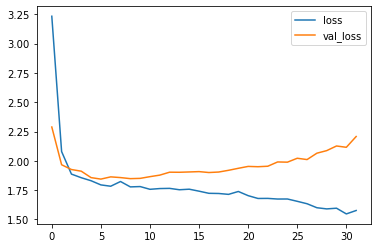

1221/1221 - 1s - loss: 1.5763 - sparse_categorical_crossentropy: 1.3701 - val_loss: 2.2075 - val_sparse_categorical_crossentropy: 1.9953
Epoch 33/50


KeyboardInterrupt: 

## Current results

...